In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
%matplotlib inline

sb.set_context('paper')

In [2]:
from utils import data
from utils.paper import mann_whitney_hyper_label_printer, fishers_exact_hyper_label_printer
cohort = data.init_cohort(exclude_patient_ids=set(), only_patients_with_bams=True)
cohort_df = cohort.as_dataframe(join_with=['pdl1'])
cohort_df['Response'] = cohort_df['benefit'].map(lambda v: cohort.benefit_plot_name if v
                                                 else 'No ' + cohort.benefit_plot_name)


annotated_effects = cohort.load_polyphen_annotations(as_dataframe=True)

{'dataframe_hash': 6797089423601767780,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with pdl1: 26 to 26 rows


In [3]:
from pyensembl import ensembl75

In [4]:
from utils.data import patient_id_to_str
kallisto_data = pd.read_csv('../bladder-kallisto-tximport.csv', index_col=0)
kallisto_data['gene_name'] = kallisto_data.index.map(lambda gid: ensembl75.gene_name_of_gene_id(gid))
kallisto_data = kallisto_data.reset_index().drop(['index'], axis=1).set_index('gene_name').T.reset_index()
kallisto_data['patient_id'] = kallisto_data['index'].map(patient_id_to_str)
kallisto_data.head()

gene_name,index,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,RPS9,PCDHB19P,PRPF31,MBOAT7,LDHAL6FP,AC005795.1,PRKCD,OR6R2P,TSEN34,patient_id
0,40,540.2140,56.00000,649.00029,830.8775,582.19160,786.00010,454.547440,4631.10524,748.34841,...,2019.060,609.9150,289.089618,558.051916,5.5000,3.55145,2297.733000,1.00419,121.806427,0040
1,471,1133.3780,77.00000,445.99969,903.3402,456.25392,342.99990,984.792258,1619.13800,989.51800,...,3040.690,107.7640,195.470580,505.955050,6.0000,6.58465,1150.999900,1.00000,315.858201,0471
2,522,1182.8780,19.00004,1216.99897,2934.5000,1905.22708,2080.99702,3423.509560,2694.14115,5283.14540,...,2943.530,21.2127,195.200002,294.738990,17.5000,6.08811,2669.242960,1.01251,4.892077,0522
3,1233,201.0806,24.00000,225.99970,616.9180,776.95600,945.99969,1183.850300,710.33517,1073.24268,...,2863.210,175.2840,123.326675,267.840510,15.7641,0.00000,774.582010,2.12905,194.579000,1233
4,1249,312.2663,163.00000,102.99996,204.7884,498.61147,107.99996,733.000220,511.54965,356.15960,...,547.199,2.5000,54.899960,22.543993,9.0000,14.53360,50.999949,0.00000,6.626220,1249


In [5]:
# Print mutated
# Plot Fisher's Exact for mutated vs not, benefit vs not
# Mann - Whitney 
# AUC with gene expression

from cohorts.plot import mann_whitney_plot, fishers_exact_plot, roc_curve_plot

def create_gene_summary(gene_name):
    mutations = annotated_effects[annotated_effects.gene == gene_name]
    expression = kallisto_data.set_index('patient_id')[[gene_name]].sum(axis=1).reset_index()
    expr_col = gene_name + ' scaledTPM'
    expression.rename(columns={0 : expr_col}, inplace=True)
    df = cohort_df.copy()
    
    mut_col = gene_name + ' Mutated'
    df[mut_col] = df.patient_id.isin(mutations.patient_id)
    
    df = df.merge(expression, how='left')
    
    if len(mutations) > 0:
        cols = 3
        width = 10
        height = 5
    else:
        cols = 2
        width = 8
        height = 4
    f, ax = plt.subplots(1, cols, figsize=(width, height))
    
    
    if len(mutations) > 0:
        mut_plot = fishers_exact_plot(data=df, condition1='Response', condition2=mut_col, ax=ax[0])
        mut_plot.plot.set_ylim(0, 1)
        fishers_exact_hyper_label_printer(mut_plot, gene_name)
        
  
    
    expr_plot = mann_whitney_plot(data=df, 
                                  condition='Response', 
                                  distribution=expr_col, 
                                  condition_value=cohort.benefit_plot_name, 
                                  ax=ax[-2])
    
    mann_whitney_hyper_label_printer(expr_plot, gene_name)
  
    expr_roc = roc_curve_plot(data=df, value_column=expr_col, outcome_column='benefit', ax=ax[-1])
    f.tight_layout()
    
    return mutations[['patient_id', 'aa_change', 'hvar_pred', 'hvar_prob', 'hdiv_pred']]

Mann-Whitney test: U=98.0, p-value=0.257704686002 (two-sided)
{{{HLA-A_plot}}}
{{{HLA-A_benefit:25457.41 (range 1923.57-82781.62)}}}
{{{HLA-A_no_benefit:9918.91 (range 596.29-62547.18)}}}
{{{HLA-A_mw:n=26, Mann-Whitney p=0.26}}}
HLA-A scaledTPM, Bootstrap (samples = 100) AUC:0.627325081602, std=0.135227549524


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


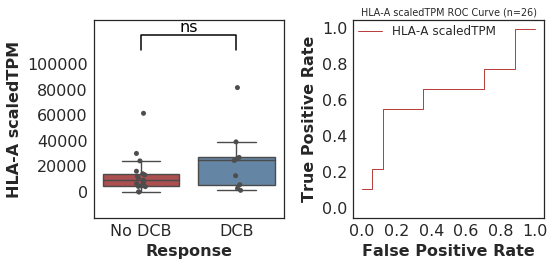

In [6]:
create_gene_summary('HLA-A')

Mann-Whitney test: U=94.0, p-value=0.359538043823 (two-sided)
{{{HLA-B_plot}}}
{{{HLA-B_benefit:10565.97 (range 1945.90-67052.75)}}}
{{{HLA-B_no_benefit:7720.74 (range 391.03-80578.17)}}}
{{{HLA-B_mw:n=26, Mann-Whitney p=0.36}}}
HLA-B scaledTPM, Bootstrap (samples = 100) AUC:0.610300052256, std=0.12094117361


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


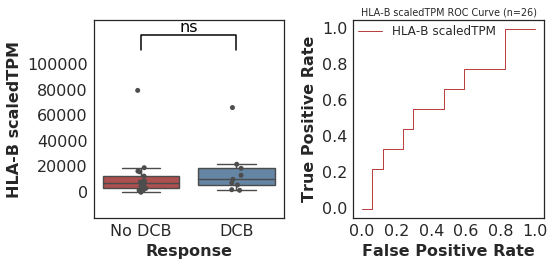

In [7]:
create_gene_summary('HLA-B')

Mann-Whitney test: U=99.0, p-value=0.235729052816 (two-sided)
{{{HLA-C_plot}}}
{{{HLA-C_benefit:15423.64 (range 1690.11-52575.19)}}}
{{{HLA-C_no_benefit:8102.90 (range 327.97-53816.39)}}}
{{{HLA-C_mw:n=26, Mann-Whitney p=0.24}}}
HLA-C scaledTPM, Bootstrap (samples = 100) AUC:0.654323353456, std=0.114955915318


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


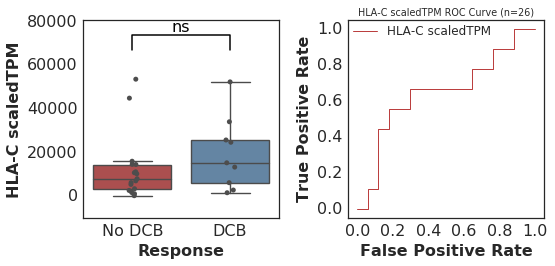

In [8]:
create_gene_summary('HLA-C')

Mann-Whitney test: U=113.0, p-value=0.0523450632732 (two-sided)
{{{TAP1_plot}}}
{{{TAP1_benefit:5511.17 (range 776.65-19455.27)}}}
{{{TAP1_no_benefit:2196.74 (range 225.34-22238.25)}}}
{{{TAP1_mw:n=26, Mann-Whitney p=0.052}}}
TAP1 scaledTPM, Bootstrap (samples = 100) AUC:0.757985898532, std=0.100883829272


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


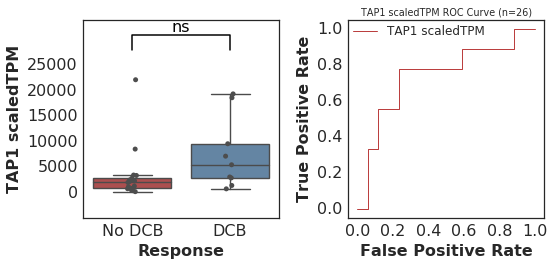

In [9]:
create_gene_summary('TAP1')

Mann-Whitney test: U=98.0, p-value=0.257704686002 (two-sided)
{{{TAP2_plot}}}
{{{TAP2_benefit:3134.31 (range 482.16-14387.11)}}}
{{{TAP2_no_benefit:2239.00 (range 331.00-13857.10)}}}
{{{TAP2_mw:n=26, Mann-Whitney p=0.26}}}
TAP2 scaledTPM, Bootstrap (samples = 100) AUC:0.641049351793, std=0.12846728123


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


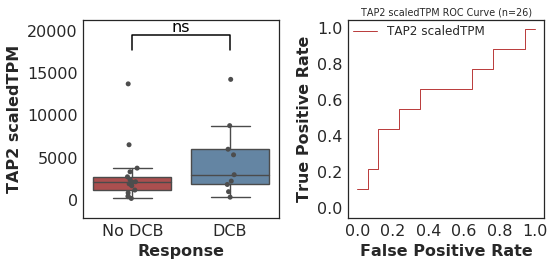

In [10]:
create_gene_summary('TAP2')

In [11]:
cohort_df[['patient_id', 'benefit']]

,patient_id,benefit
0,0040,False
1,0471,False
2,0522,False
3,1233,True
4,1249,False
5,1849,True
6,1994,False
7,2131,True
8,2278,True
9,2389,True


In [12]:
cohort_df[['patient_id', 'benefit', 'pfs', 'progressed']]

,patient_id,benefit,pfs,progressed
0,0040,False,20,True
1,0471,False,61,True
2,0522,False,58,True
3,1233,True,398,True
4,1249,False,41,True
5,1849,True,265,True
6,1994,False,121,True
7,2131,True,560,False
8,2278,True,655,False
9,2389,True,646,False
